In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced', force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dilluminati09
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced


100%|██████████| 1.90G/1.90G [00:02<00:00, 997MB/s]


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import shap
import pandas as pd

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# Loading Dataset
train_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=5, ignore_mismatched_sizes=True
)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-8-39165d37fbef>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [10]:
def train(model, train_loader, val_loader, epochs=10):
    training_results = []
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images).logits
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_acc = correct / len(train_loader.dataset)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Train Accuracy: {train_acc:.4f}")
        print(f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}")

        training_results.append([epoch+1, total_loss/len(train_loader), train_acc, train_precision, train_recall, train_f1])
        test(model, val_loader)

    df_train = pd.DataFrame(training_results, columns=['Epoch', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    df_train.to_csv("/content/training_results.csv", index=False)

In [11]:
def test(model, val_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    classification_results = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images).logits
            predictions = outputs.argmax(1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                classification_results.append([labels[i].item(), predictions[i].item()])

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    df_classification = pd.DataFrame(classification_results, columns=['Actual', 'Predicted'])
    df_classification.to_csv("/content/classification_results.csv", index=False)

    visualize_gradcam(model, val_loader)

In [12]:
# Grad-CAM Visualization
def visualize_gradcam(model, dataloader):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    model.eval()
    outputs = model(images).logits
    predictions = outputs.argmax(1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {predictions[i].item()}, Actual: {labels[i].item()}")
        axes[i].axis("off")
    plt.show()

In [13]:
def shap_explain(model, dataloader):
    model.eval()
    batch = next(iter(dataloader))[0][:10].to(device)
    explainer = shap.GradientExplainer(model, batch)
    shap_values = explainer.shap_values(batch)
    shap.image_plot(shap_values, batch.cpu().numpy())

In [14]:
train(model, train_loader, val_loader, epochs=30)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
torch.save(model.state_dict(), '/content/model.pth')

In [16]:
def plot_training_results():
    df = pd.read_csv("training_results.csv")
    plt.figure(figsize=(10, 5))
    plt.plot(df['Epoch'], df['Accuracy'], label='Accuracy')
    plt.plot(df['Epoch'], df['Loss'], label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Training Performance')
    plt.show()

In [17]:
def plot_classification_results():
    df = pd.read_csv("classification_results.csv")
    plt.figure(figsize=(6, 4))
    plt.hist(df['Actual'], bins=50, alpha=0.5, label='Actual')
    plt.hist(df['Predicted'], bins=50, alpha=0.5, label='Predicted')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend()
    plt.title('Classification Distribution')
    plt.show()

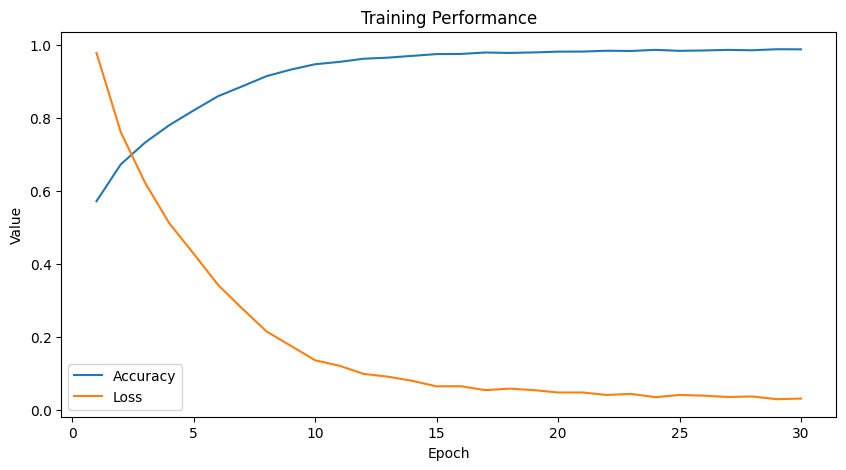

In [18]:
plot_training_results()


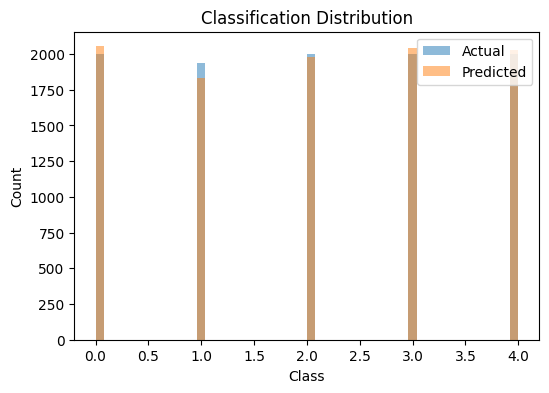

In [19]:
plot_classification_results()